In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)  
from dask.distributed import Client
import dask.array as da

In [2]:
# client = Client()
# client

# Access MOANA rasters

In [3]:
auth = earthaccess.login()

In [4]:
tspan = ("2024-04-01", "2025-08-31")

In [5]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable
    Args:
        ds: a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    return ds

In [6]:
results_moana = earthaccess.search_data(
    short_name="PACE_OCI_L3M_MOANA",
    granule_name="*.Day.*0p1deg*",  # Daily: Day | Resolution: 0p1deg or 4 (for 4km)
    temporal=tspan,
)

In [7]:
path_files_moana = earthaccess.open(results_moana)

QUEUEING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/376 [00:00<?, ?it/s]

In [8]:
dataset_moana = xr.open_mfdataset(
    path_files_moana, preprocess=time_from_attr, combine="nested", concat_dim="date"
    #, chunks={"latitude": 100, "longitude": 100}
)

## Clean data

In [9]:
dataset_moana["prococcus_moana"] = dataset_moana["prococcus_moana"].clip(
    min=dataset_moana["prococcus_moana"].attrs["valid_min"],
    max=dataset_moana["prococcus_moana"].attrs["valid_max"],
)
dataset_moana["syncoccus_moana"] = dataset_moana["syncoccus_moana"].clip(
    min=dataset_moana["syncoccus_moana"].attrs["valid_min"],
    max=dataset_moana["syncoccus_moana"].attrs["valid_max"],
)
dataset_moana["picoeuk_moana"] = dataset_moana["picoeuk_moana"].clip(
    min=dataset_moana["picoeuk_moana"].attrs["valid_min"],
    max=dataset_moana["picoeuk_moana"].attrs["valid_max"],
) 

In [10]:
dataset_phy = dataset_moana.drop_vars(["palette"])

In [74]:
dataset_phy

<xarray.Dataset> Size: 7GB
Dimensions:          (date: 376, lat: 1400, lon: 1100)
Coordinates:
  * lat              (lat) float32 6kB 69.95 69.85 69.75 ... -69.85 -69.95
  * lon              (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.85 24.95
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Data variables:
    prococcus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         166600
    data_minimum:                      -inf
    data_maximum:                      inf

In [11]:
moana_pcc_monthly_mean = dataset_phy.resample(date="1M").mean("date")

In [152]:
#plot = moana_pcc_monthly_mean["syncoccus_moana"].mean("date").plot.imshow(robust="true")

# Access PACE BGC rasters

## PACE POC

In [76]:
# results_pace_poc = earthaccess.search_data(
#     short_name="PACE_OCI_L3M_POC",
#     granule_name="*.Day.*0p1deg*",  # Daily: Day | Resolution: 0p1deg or 4 (for 4km)
#     temporal=tspan,
# )

In [13]:
path_files_poc = earthaccess.open(results_pace_poc)

QUEUEING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/387 [00:00<?, ?it/s]

In [14]:
# dataset_pace_poc = xr.open_mfdataset(
#     path_files_poc, preprocess=time_from_attr, combine="nested", concat_dim="date"
#     #chunks={"latitude": 100, "longitude": 100}
# )
# dataset_pace_poc

<xarray.Dataset> Size: 10GB
Dimensions:  (date: 387, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date     (date) datetime64[ns] 3kB 2024-03-31T23:33:05 ... 2025-05-01T23:...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    poc      (date, lat, lon) float32 10GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 297kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240401.L3m.DAY.POC.V3_0.poc...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/POC/3.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         554519
    data_minimum:                      9.0
    data_maximum:                      1953.0

### Clean data

In [15]:
# dataset_pace_poc["poc"] = dataset_pace_poc["poc"].clip(
#     min=dataset_pace_poc["poc"].attrs["valid_min"],
#     max=dataset_pace_poc["poc"].attrs["valid_max"],
# )

# dataset_pace_poc = dataset_pace_poc.drop_vars(["palette"])

In [16]:
# pace_poc_monthly_mean = dataset_pace_poc.resample(date="1M").mean("date")

## PACE Carbon

In [17]:
results_pace_car = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CARBON",
    granule_name="*.Day.*0p1deg*",  # Daily: Day | Resolution: 0p1deg or 4 (for 4km)
    temporal=tspan,
)

In [18]:
path_files_car = earthaccess.open(results_pace_car)

QUEUEING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/387 [00:00<?, ?it/s]

In [19]:
dataset_pace_car = xr.open_mfdataset(
    path_files_car, preprocess=time_from_attr, combine="nested", concat_dim="date"
    #chunks={"latitude": 100, "longitude": 100}
)
dataset_pace_car

<xarray.Dataset> Size: 10GB
Dimensions:       (date: 387, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat           (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon           (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date          (date) datetime64[ns] 3kB 2024-03-31T23:33:05 ... 2025-05-0...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    carbon_phyto  (date, lat, lon) float32 10GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette       (date, rgb, eightbitcolor) uint8 297kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.CARBON.V3_0....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CARBON/3.0
    data_bins:                         554626
    data_minimum:                      0.59064007
    data_maximum:                      1000.0002

### Clean data

In [20]:
dataset_pace_car["carbon_phyto"] = dataset_pace_car["carbon_phyto"].clip(
    min=dataset_pace_car["carbon_phyto"].attrs["valid_min"],
    max=dataset_pace_car["carbon_phyto"].attrs["valid_max"],
)

dataset_pace_car = dataset_pace_car.drop_vars(["palette"])

In [21]:
pace_car_monthly_mean = dataset_pace_car.resample(date="1M").mean("date")

## PACE Chl

In [22]:
results_pace_chl = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    granule_name="*.Day.*0p1deg*",  # Daily: Day | Resolution: 0p1deg or 4 (for 4km)
    temporal=tspan,
)

In [23]:
path_files_chl = earthaccess.open(results_pace_chl)

QUEUEING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/387 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/387 [00:00<?, ?it/s]

In [24]:
dataset_pace_chl = xr.open_mfdataset(
    path_files_chl, preprocess=time_from_attr, combine="nested", concat_dim="date"
    #chunks={"latitude": 100, "longitude": 100}
)
dataset_pace_chl

<xarray.Dataset> Size: 10GB
Dimensions:  (date: 387, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * date     (date) datetime64[ns] 3kB 2024-03-31T23:33:05 ... 2025-05-01T23:...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 10GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 297kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240401.L3m.DAY.CHL.V3_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         555432
    data_minimum:                      0.005920372
    data_maximum:                      90.442894

### Clean data

In [25]:
dataset_pace_chl["chlor_a"] = dataset_pace_chl["chlor_a"].clip(
    min=dataset_pace_chl["chlor_a"].attrs["valid_min"],
    max=dataset_pace_chl["chlor_a"].attrs["valid_max"],
)

dataset_pace_chl = dataset_pace_chl.drop_vars(["palette"])

In [26]:
pace_chl_monthly_mean = dataset_pace_chl.resample(date="1M").mean("date")

# MOANA vs PACE

In [27]:
# MOANA monthly composites 
pro = moana_pcc_monthly_mean["prococcus_moana"]
syn = moana_pcc_monthly_mean["syncoccus_moana"]
euk = moana_pcc_monthly_mean["picoeuk_moana"]

diam_pro = 0.68
diam_syn = 1.22
diam_euk = 1.56

carpVol_pro = 214
carpVol_syn = 203
carpVol_euk = 220

cVol_pro = (diam_pro/2)**3 * np.pi * 4/3
cVol_syn = (diam_syn/2)**3 * np.pi * 4/3
cVol_euk = (diam_euk/2)**3 * np.pi * 4/3

# Convert to µg C/L
C_pro = pro * carpVol_pro * cVol_pro * 10**-6
C_syn = syn * carpVol_syn * cVol_syn * 10**-6
C_euk = euk * carpVol_euk * cVol_euk * 10**-6

# Total MOANA-derived carbon
C_moana_total = C_pro + C_syn + C_euk

In [121]:
#plot = C_moana_total.mean("date").plot.imshow(robust="true")

In [123]:
#plot = C_moana_total.isel(date = 6).plot.imshow(robust="true")

In [124]:
# PACE-derived total phytoplankton carbon
C_pace_total = pace_car_monthly_mean["carbon_phyto"]

# Match the chl-a data to the residual grid
C_pace_total_clipped = C_pace_total.reindex_like(C_moana_total, method = "nearest")
C_pace_total = C_pace_total_clipped

In [125]:
# plot = C_pace_total_clipped.isel(date = 6).plot.imshow(robust="true")

In [30]:
#print("MOANA Cphyto range:", C_moana_total.isel(date=0).min().values, C_moana_total.isel(date=0).max().values,  C_moana_total.isel(date=0).mean().values)
#print("PACE Cphyto range:", C_pace_total.isel(date=0).min().values, C_pace_total.isel(date=0).max().values,  C_pace_total.isel(date=0).mean().values)

In [126]:
residual = xr.where(
    C_pace_total.notnull() & C_moana_total.notnull(),
    C_pace_total - C_moana_total,
    np.nan
)

fraction_explained = xr.where(
    C_pace_total.notnull() & C_moana_total.notnull(),
    C_moana_total / C_pace_total,
    np.nan
)

residual_percent = xr.where(
    C_pace_total.notnull() & C_moana_total.notnull(),
    100 * residual / C_pace_total,
    np.nan
)

In [85]:
#print("PACE Cphyto range:", residual.isel(date=0).min().values, residual.isel(date=0).max().values,  residual.isel(date=0).mean().values)

In [112]:
# Select october for PACE/MOANA
oct_resid = residual.isel(date=6)
oct_fraction = fraction_explained.isel(date = 6)
oct_resid_perc = residual_percent.isel(date = 6)


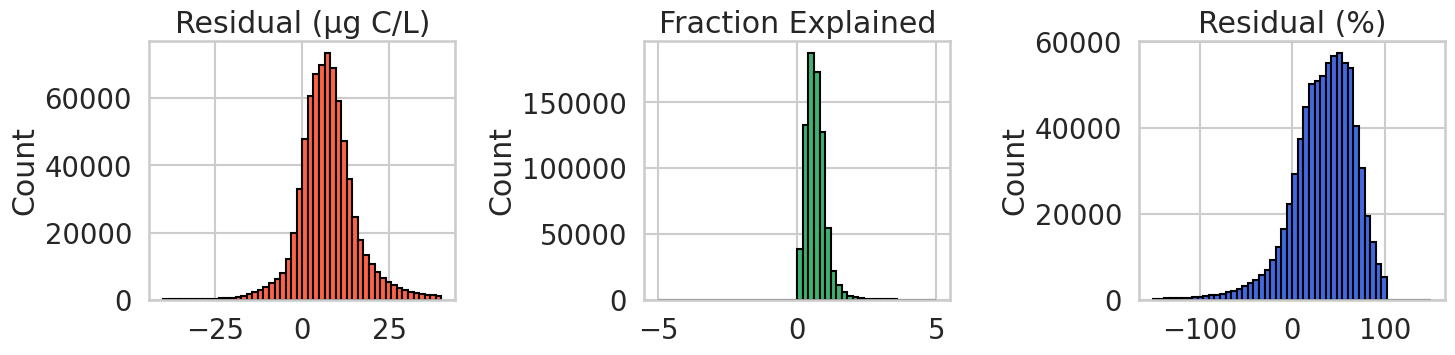

In [137]:
# Flatten and remove NaNs
resid_vals = oct_resid.values.flatten()
resid_vals = resid_vals[~np.isnan(resid_vals)]

frac_vals = oct_fraction.values.flatten()
frac_vals = frac_vals[~np.isnan(frac_vals)]

perc_vals = oct_resid_perc.values.flatten()
perc_vals = perc_vals[~np.isnan(perc_vals)]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].hist(resid_vals, bins=50, color='tomato', edgecolor='black', range=(-40, 40))
axs[0].set_title("Residual (µg C/L)")

axs[1].hist(frac_vals, bins=50, color='mediumseagreen', edgecolor='black', range=(-5, 5))
axs[1].set_title("Fraction Explained")

axs[2].hist(perc_vals, bins=50, color='royalblue', edgecolor='black', range=(-150, 150))
axs[2].set_title("Residual (%)")

for ax in axs:
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [128]:
# Select October for PACE Chl
oct_chl = pace_chl_monthly_mean["chlor_a"].isel(date = 6)

# Match the chl-a data to the residual grid
oct_chl_interp = oct_chl.reindex_like(C_moana_total, method = "nearest")
oct_chl = oct_chl_interp

In [129]:
#plot = oct_resid.plot.imshow(robust="true")

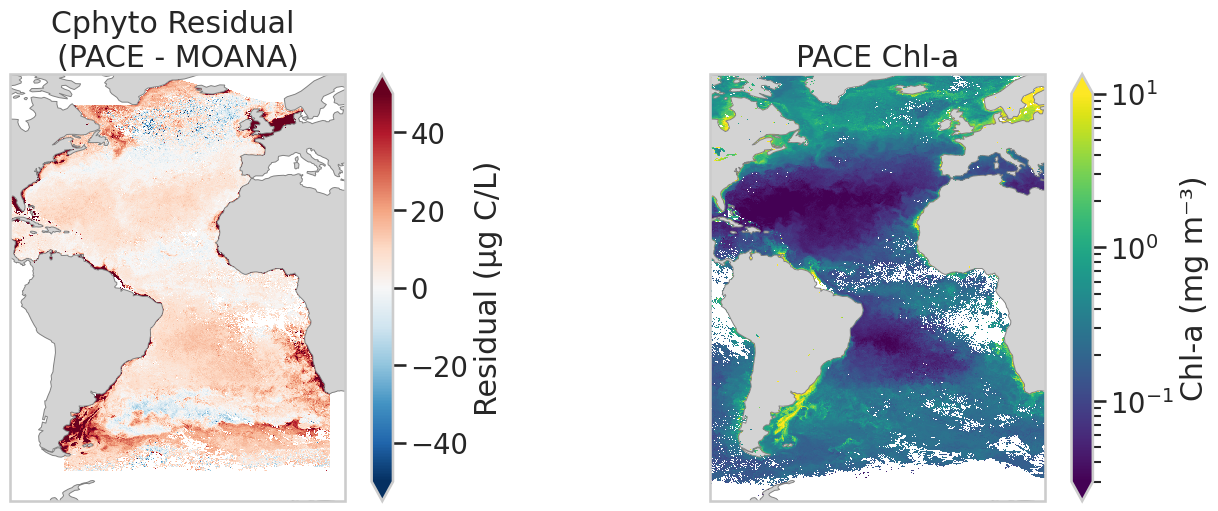

In [143]:
# Set up figure with Cartopy axes
fig, axs = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={"projection": ccrs.PlateCarree()}, constrained_layout=True)

# Residual map (PACE - MOANA)
im0 = oct_resid.plot.pcolormesh(
    ax=axs[0],
    cmap="RdBu_r",
    vmin=-50, 
    vmax=50,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Residual (µg C/L)"}
)
axs[0].set_title("Cphyto Residual \n(PACE - MOANA)")
axs[0].add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
axs[0].coastlines(color = "grey", linewidth = 0.7)
#axs[0].set_extent([oct_resid.lon.min(), oct_resid.lon.max(), oct_resid.lat.min(), oct_resid.lat.max()])

# Chl-a map
im1 = oct_chl.plot.pcolormesh(
    ax=axs[1],
    cmap="viridis",
    norm=plt.matplotlib.colors.LogNorm(vmin=0.03, vmax=10),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Chl-a (mg m⁻³)"}
)
axs[1].set_title("PACE Chl-a")
axs[1].add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
axs[1].coastlines(color = "grey", linewidth = 0.7)
#axs[1].set_extent([oct_resid.lon.min(), oct_resid.lon.max(), oct_resid.lat.min(), oct_resid.lat.max()])

plt.savefig("Figures/oct_cphyto_resids_chl.png", dpi = 300)

plt.show()


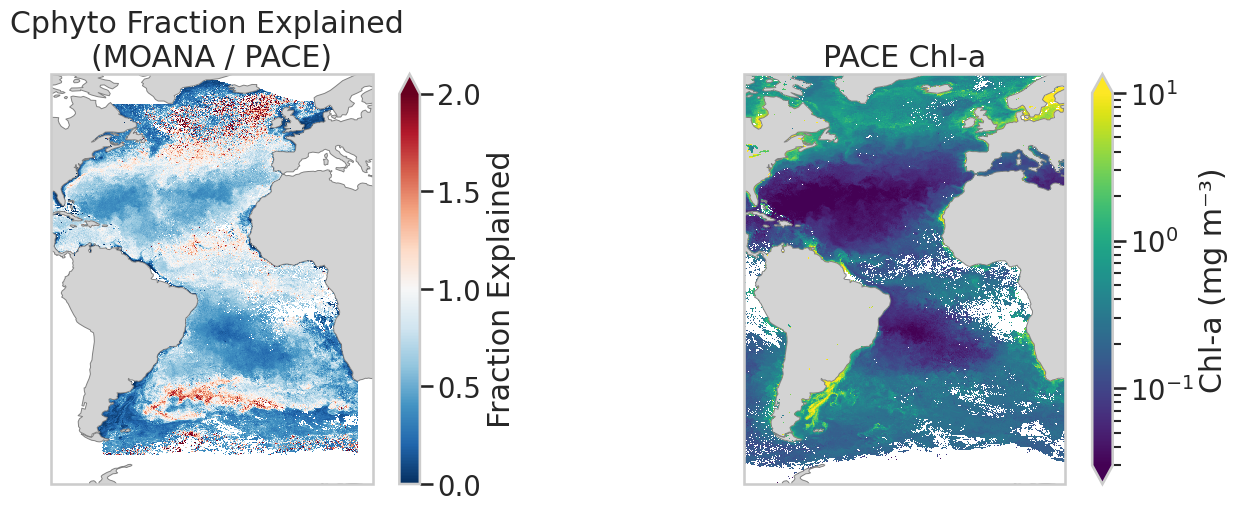

In [151]:
# Set up figure with Cartopy axes
fig, axs = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={"projection": ccrs.PlateCarree()}, constrained_layout=True)

# Residual map (PACE - MOANA)
im0 = oct_fraction.plot.pcolormesh(
    ax=axs[0],
    cmap="RdBu_r",
    vmin=0, 
    vmax=2,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Fraction Explained"}
)
axs[0].set_title("Cphyto Fraction Explained \n(MOANA / PACE)")
axs[0].add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
axs[0].coastlines(color = "grey", linewidth = 0.7)

# Chl-a map
im1 = oct_chl.plot.pcolormesh(
    ax=axs[1],
    cmap="viridis",
    norm=plt.matplotlib.colors.LogNorm(vmin=0.03, vmax=10),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Chl-a (mg m⁻³)"}
)
axs[1].set_title("PACE Chl-a")
axs[1].add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
axs[1].coastlines(color = "grey", linewidth = 0.7)

plt.savefig("Figures/oct_cphyto_fract_explained_chl.png", dpi = 300)

plt.show()


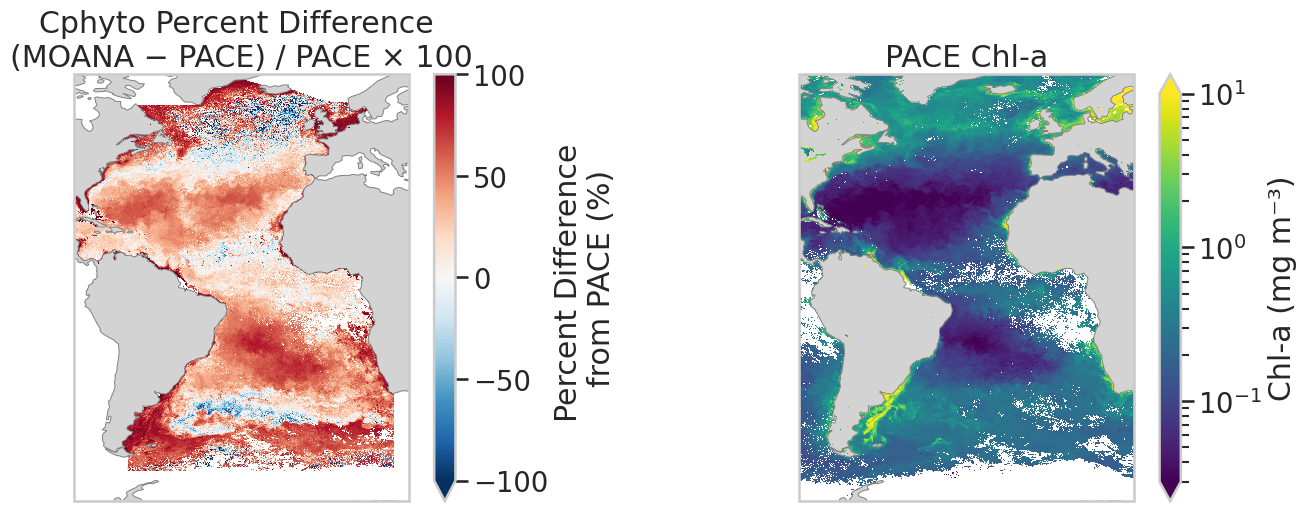

In [148]:
# Set up figure with Cartopy axes
fig, axs = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={"projection": ccrs.PlateCarree()}, constrained_layout=True)

# Residual map (PACE - MOANA)
im0 = oct_resid_perc.plot.pcolormesh(
    ax=axs[0],
    cmap="RdBu_r",
    vmin=-100, 
    vmax=100,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Percent Difference \nfrom PACE (%)"}
)
axs[0].set_title("Cphyto Percent Difference \n(MOANA − PACE) / PACE × 100")
axs[0].add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
axs[0].coastlines(color = "grey", linewidth = 0.7)

# Chl-a map
im1 = oct_chl.plot.pcolormesh(
    ax=axs[1],
    cmap="viridis",
    norm=plt.matplotlib.colors.LogNorm(vmin=0.03, vmax=10),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Chl-a (mg m⁻³)"}
)
axs[1].set_title("PACE Chl-a")
axs[1].add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
axs[1].coastlines(color = "grey", linewidth = 0.7)

plt.savefig("Figures/oct_cphyto_resids_percent_chl.png", dpi = 300)

plt.show()
